In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


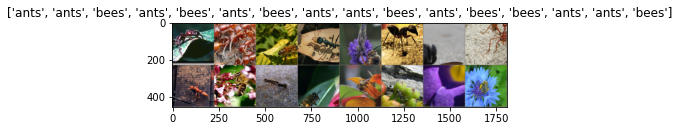

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
# model_ft = models.MobileNetV2()
print(model_ft)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

Using cache found in /home/ben/.cache/torch/hub/pytorch_vision_v0.9.0


In [7]:
model_ft.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [8]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)
#
# model_ft = model_ft.to(device)
#
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#
# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

In [10]:
# visualize_model(model_ft)

In [11]:
class Addhead(nn.Module):
    def __init__(self, logits_model, input_size):
        super(Addhead,self).__init__()
        self.logit_model = logits_model
        self.dense1 = nn.Linear(input_size,1)
        self.to_probs = torch.nn.Sigmoid()

    def forward(self, inputs):
        logits = self.logit_model(inputs)
        outs = self.dense1(logits)
        probs = self.to_probs(outs)
        return probs

In [12]:
import logictensornetworks as ltn

In [13]:
class Ident(nn.Module):
    def __init__(self):
        super(Ident, self).__init__()
    def forward(self,x):
        return x

In [14]:
modell = model_ft
modell.classifier[1]  = Ident()

for parameter in modell.parameters():
    parameter.requires_grad = False

In [15]:
bees = ltn.Predicate(Addhead(modell,1280))
ants = ltn.Predicate(Addhead(modell,1280))

In [16]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2,stable=True),semantics="forall")

formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2,stable=True)

In [17]:
def axioms(data, labels):
    x_A = ltn.variable("x_A",data[labels])
    x_A.to(device)
    x_not_A = ltn.variable("x_not_A",data[torch.logical_not(labels)])
    x_not_A.to(device)
    axioms = [
        Forall(x_A, bees(x_A)),
        Forall(x_not_A, Not(bees(x_not_A))),
        Forall(x_not_A, ants(x_not_A)),
        Forall(x_A, Not(ants(x_A)))
    ]
    axioms = torch.stack(axioms)
    sat_level = formula_aggregator(axioms, axis=0)
    return sat_level, axioms

In [18]:
trainable_variables = set(bees.parameters()) | set(ants.parameters())

In [ ]:
for _data, _labels in dataloaders['train']:
    _data.to(device)
    _labels.to(device)
    print("Initial sat level %.5f"%axioms(_data, _labels)[0])
    break
axioms(_data, _labels)


In [19]:
trainable_variables = set(bees.parameters()) | set(ants.parameters())
optimizer = torch.optim.Adam(trainable_variables, lr=0.001)
for epoch in range(10):
    for _data, _labels in dataloaders['train']:
        optimizer.zero_grad()
        sat = axioms(_data,_labels)[0]
        loss = 1.- sat
        loss.backward()
        # nn.utils.clip_grad_norm(trainable_variables,2.)
        optimizer.step()
    if epoch%1== 0:
        print("Epoch %d: (Train) Sat Level %.3f"%(epoch,sat))
        #mean_metrics.reset_states()
        with torch.no_grad():
            test_sats = []
            for _data, _labels in dataloaders['val']:
                #mean_metrics(axioms(_data, _labels)[0])
                test_sats.append(axioms(_data,_labels)[0])
        print("Epoch %d: (Test) Sat Level %.3f"%(epoch, torch.mean(torch.stack(test_sats)) ))
#mean_metrics.reset_states()
test_sats = []
for _data, _labels in dataloaders['val']:
    test_sats.append(axioms(_data,_labels)[0])
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, torch.mean(torch.stack(test_sats)) ))

Epoch 0: (Train) Sat Level 0.517
Epoch 0: (Test) Sat Level 0.497


KeyboardInterrupt: 

In [ ]:
inputs, classes = next(iter(dataloaders['train']))


In [ ]:
for _data, _labels in dataloaders['train']:
    _data.to(device)
    _labels.to(device)
    print("Initial sat level %.5f"%axioms(_data, _labels)[0])
    break
axioms(_data, _labels)